# Machine translation

I made this project to get more familiar with NLP and learn something about Machine translation, as well as practice working with torch and torchtext. The ultimate goal was to create a machine translation pipeline, going from raw data to trained algorithm, and adjust it according to currently used data / architecture. This notebook puts all the modules together.

I won't present all the code here. For anyone curious, I encourage you to check out the source code. Set up GPU is assumed.

### Prerequisities

##### Datasets

WMT14
- download https://1drv.ms/f/s!AiQ5a2cXVytTlkZD0HQn5FdGRgB2
- move to data/WMT14

Multi30k
- download https://1drv.ms/f/s!AiQ5a2cXVytTllU4usk93QbPGv1s
- move to data/Multi30k

##### Environment

I highly recommend setting up a conda environment before installing packages.
- navigate to root
- pip install -r requirements.txt

Also, while in environment, do this:
`python -m spacy download en`

##### Trained models

LSTM RNN
- download https://1drv.ms/f/s!AiQ5a2cXVytTmUHOdj_FIim0ge2P
- move to models/LSTM_RNN

RNNsearch
- download https://1drv.ms/f/s!AiQ5a2cXVytTmUTIIBY09Kq4NSC4
- move to models/RNNsearch 

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

import time

from src.data.loader import load_multi30k, load_WMT14
from src.data.raw_to_proc import proc_WMT14, proc_multi30k, create_WMT14_samp
from src.models.lstm_rnn import SimpleEncoder,SimpleEncoderVLS,SimpleDecoder
from src.models.RNN_search import AttnEncoder, AttnDecoder
from src.models import translate
from src.models.fit import RNNsearch_Learner, LSTM_RNN_Learner, LSTM_RNN_VLS_Learner
from src.utils import plotAttention

import torch
import torch.nn.functional as F
import torch.optim as optim

### Data preprocessing

##### Restructuring

Although the downloads provide both raw and processed datasets, I would like to share functions used on raw data to create the processed data.

In [ ]:
proc_multi30k()
proc_WMT14()
create_WMT14_samp()

##### Accessing data

These functions are used to get access to 3 dataset loaders - WMT14 with batch size 1, Multi30k with batch size 1 and Multi30k with custom batch size (I chose 32). My implementation doesn't support other batch sizes for WMT14. The two variants of Multi30k will be used to showcase certain features of batching when using RNNs.

WMT14 dataset is czech-english, Multi30k is german-english. We are going to translate to english in both cases, hence TRG corresponds to english vocab and SRC corresponds to either czech or german vocab. The src and trg variables refer to names of fields in dataset (taking look at the source code could help understand what's going on).

In [ ]:
train_iter, valid_iter, SRC, TRG = load_WMT14(1)
src, trg = 'src','trg'
ds_name = 'WMT14'

In [2]:
train_iter, valid_iter, SRC, TRG = load_multi30k(1)
src, trg = 'de','en'
ds_name = 'Multi30k'

In [2]:
train_iter, valid_iter, SRC, TRG = load_multi30k(32)
src, trg = 'de','en'
ds_name = 'Multi30k'

Let's set some useful variables too.

In [3]:
n_words_src = len(SRC.vocab)
n_words_trg = len(TRG.vocab)

In [4]:
pad_src_id = SRC.vocab.stoi['<pad>']
pad_trg_id = TRG.vocab.stoi['<pad>']

In [5]:
trg_sos_id = TRG.vocab.stoi['<SOS>']
trg_eos_id = TRG.vocab.stoi['<EOS>']
src_eos_id = SRC.vocab.stoi['<EOS>']

In [6]:
train_len = len(train_iter)
val_len = len(valid_iter)

### Models

##### LSTM RNN

In [7]:
model_name = 'LSTM_RNN'

Setting some basic parameters for network - sizes of embedding vectors and hidden layers.

In [8]:
embedding_size_src = 300
embedding_size_trg = 300

In [9]:
n_hidden_src = 200
n_hidden_trg = 200

This is the most basic type of model we will use. For practical reasons, we are going to treat encoder and decoder separately. The pair below is only capable of single-sequence input processing.

In [112]:
enc = SimpleEncoder(n_words_src,embedding_size_src,n_hidden_src).cuda()
dec = SimpleDecoder(n_words_trg,embedding_size_trg,n_hidden_trg).cuda()

The pair below is able to work with batch of VLS (variable length sequences). Because we are working with RNNs, parallel computation isn't as straightforward as in the case of other architectures, especially in our case with big amount of short sequences of variable lengths. The real dealbreaker here is the fact that we have pairs of sequences, meaning we can't simply join together the ones with least padding. As a solution, I have tried to implement PyTorch PackedSequence objects, with at least some succes. 

In [10]:
enc = SimpleEncoderVLS(n_words_src,embedding_size_src,n_hidden_src,pad_src_id).cuda()
dec = SimpleDecoder(n_words_trg,embedding_size_trg,n_hidden_trg).cuda()

The hyperparameters used can be changed as needed.

##### RNNsearch

In [7]:
model_name = 'RNNsearch'

Here we also need to set some additional parameters - number of layers in encoder / decoder and number of hidden units in alignment network.

In [8]:
embedding_size_src = 200
embedding_size_trg = 200

In [9]:
n_hidden_src = 150
n_hidden_trg = 150

In [10]:
n_layers_src = 1
n_layers_trg = 1

In [11]:
n_allign = 150

In [12]:
bidirectional = True
n_dir_enc = 1 if not bidirectional else 2

In [13]:
n_l = 150

In this case, I wasn't able (yet) to come up with a solution for parallel computation of batches of data, so here I only provide model capable of using only one example at a time.

In [14]:
enc = AttnEncoder(n_words_src,embedding_size_src,n_hidden_src,n_layers_src,bidirectional=True).cuda()
dec = AttnDecoder(n_words_trg,embedding_size_trg,n_hidden_trg,n_hidden_src,n_dir_enc,n_allign,
                  n_layers_trg, n_l).cuda()

The hyperparameters used can be changed as needed.

### Training 

##### LSTM RNN

Setting up some training parameters - optimizers, learning rate, loss function, number of epochs

In [11]:
opt_enc = optim.Adadelta(enc.parameters())
opt_dec = optim.Adadelta(dec.parameters())
loss_fn = F.nll_loss
epochs = 1

In [113]:
model_path_Multi30k = 'models/LSTM_RNN/Multi30k/'
model_path_WMT14 = 'models/LSTM_RNN/WMT14/'

This set of functions should be used for non-VLS model. As can be seen, manual teacher forcing scheduling is done in this case. In order to manipulate length of training you can change the end_train and end_val parameters. Every epoch the models are automatically saved - loading them is covered later.

In [15]:
t0 = time.time()

In [16]:
batch_size = 1
plot_every = int(train_len/30) # 30 points / epoch will be plotted
end_train = train_len
end_val = int(val_len/10)
teacher_forcing = 0.8

Choose one - Multi30k learner / WMT14 learner

In [ ]:
learner = LSTM_RNN_Learner([enc, dec], [opt_enc, opt_dec], 
                           loss_fn, model_path_Multi30k)

In [ ]:
learner = LSTM_RNN_Learner([enc, dec], [opt_enc, opt_dec], 
                           loss_fn, model_path_WMT14)

Begin training sequence

In [17]:
learner.train(train_iter, valid_iter, epochs, batch_size, plot_every, 
              end_train, end_val, src, trg, n_words_trg, teacher_forcing)

10.0% done
20.0% done
Train: 5.859718976634563 
Valid: 5.653533758503376 

30.0% done
40.0% done
Train: 5.499934184669268 
Valid: 5.676446093191014 

50.0% done
60.0% done
Train: 5.298372957966115 
Valid: 5.372390836772352 

70.0% done
80.0% done
Train: 5.409671908558005 
Valid: 5.037766279560505 

90.0% done
100.0% done
Train: 5.398126632860391 
Valid: 5.182071826245525 



In [18]:
teacher_forcing = 0.6

In [19]:
learner.train(train_iter, valid_iter, epochs, batch_size, plot_every, 
              end_train, end_val, src, trg, n_words_trg, teacher_forcing)

10.0% done
20.0% done
Train: 5.039050196657087 
Valid: 5.181003508001271 

30.0% done
40.0% done
Train: 5.0462018876972765 
Valid: 5.107460155345426 

50.0% done
60.0% done
Train: 5.182270480854677 
Valid: 5.07077419875872 

70.0% done
80.0% done
Train: 5.125636315581822 
Valid: 4.995105342109604 

90.0% done
100.0% done
Train: 5.0669068487563935 
Valid: 4.96810502817135 



In [20]:
teacher_forcing = 0.4

In [21]:
learner.train(train_iter, valid_iter, epochs, batch_size, plot_every, 
              end_train, end_val, src, trg, n_words_trg, teacher_forcing)

10.0% done
20.0% done
Train: 4.881178612756257 
Valid: 5.005245416471274 

30.0% done
40.0% done
Train: 5.051450948904057 
Valid: 4.868481581754024 

50.0% done
60.0% done
Train: 4.746594539963373 
Valid: 4.88714057620209 

70.0% done
80.0% done
Train: 4.708701044025988 
Valid: 4.750287104361128 

90.0% done
100.0% done
Train: 4.854624711640991 
Valid: 4.784129020011071 



In [22]:
teacher_forcing = 0.2

In [23]:
learner.train(train_iter, valid_iter, epochs, batch_size, plot_every, 
              end_train, end_val, src, trg, n_words_trg, teacher_forcing)

10.0% done
20.0% done
Train: 4.7720833993194125 
Valid: 4.793815859473578 

30.0% done
40.0% done
Train: 4.778045682623835 
Valid: 4.720992981797398 

50.0% done
60.0% done
Train: 4.548701863477726 
Valid: 4.929835203850623 

70.0% done
80.0% done
Train: 4.890542277015082 
Valid: 4.801950160819705 

90.0% done
100.0% done
Train: 4.788531976171059 
Valid: 4.909148868947926 



In [24]:
teacher_forcing = 0

In [25]:
learner.train(train_iter, valid_iter, epochs, batch_size, plot_every, 
              end_train, end_val, src, trg, n_words_trg, teacher_forcing)

10.0% done
20.0% done
Train: 4.41934333343317 
Valid: 4.839534026561397 

30.0% done
40.0% done
Train: 4.90981662155378 
Valid: 4.9470441317794345 

50.0% done
60.0% done
Train: 4.806883782443434 
Valid: 4.87801193482805 

70.0% done
80.0% done
Train: 4.596715621428914 
Valid: 4.821538231160381 

90.0% done
100.0% done
Train: 4.801903214785132 
Valid: 4.800157905805229 



In [26]:
t1 = time.time()
t1-t0

7154.458283901215

This function should be used to train the VLS model.

In [ ]:
learner = LSTM_RNN_VLS_Learner([enc, dec], [opt_enc, opt_dec], 
                               loss_fn, path_to_directory)

In [21]:
learner.train(train_iter, valid_iter, epochs, batch_size, plot_every, 
              end_train, end_val, src, trg, n_words_trg, teacher_forcing, 
              pad_src_id, pad_trg_id)

0.6% done
1.1% done
1.7% done
2.2% done
2.8% done
3.3% done
3.9% done
4.4% done
5.0% done
5.5% done
6.1% done
6.6% done
7.2% done
7.7% done
8.3% done
8.8% done
9.4% done
9.9% done
10.5% done
11.0% done
11.6% done
12.2% done
12.7% done
13.3% done
13.8% done
14.4% done
14.9% done
15.5% done
16.0% done
16.6% done
17.1% done
17.7% done
18.2% done
18.8% done
19.3% done
19.9% done
Train: 5.073108215524693 
Valid: 5.1813329735187565 

20.4% done
21.0% done
21.5% done
22.1% done
22.7% done
23.2% done
23.8% done
24.3% done
24.9% done
25.4% done
26.0% done
26.5% done
27.1% done
27.6% done
28.2% done
28.7% done
29.3% done
29.8% done
30.4% done
30.9% done
31.5% done
32.0% done
32.6% done
33.1% done
33.7% done
34.3% done
34.8% done
35.4% done
35.9% done
36.5% done
37.0% done
37.6% done
38.1% done
38.7% done
39.2% done
39.8% done
Train: 5.2609340686990755 
Valid: 5.150072846749817 

40.3% done
40.9% done
41.4% done
42.0% done
42.5% done
43.1% done
43.6% done
44.2% done
44.8% done
45.3% done
45.9% do

Loading / saving Multi30k models

In [114]:
enc.load_state_dict(torch.load(f'{model_path_Multi30k}enc.pt'))
dec.load_state_dict(torch.load(f'{model_path_Multi30k}dec.pt'))

In [28]:
torch.save(enc.state_dict(), f'{model_path_Multi30k}enc.pt')
torch.save(dec.state_dict(), f'{model_path_Multi30k}dec.pt')

Loading / saving WMT14 models

In [18]:
enc.load_state_dict(torch.load(f'{model_path_WMT14}enc.pt'))
dec.load_state_dict(torch.load(f'{model_path_WMT14}dec.pt'))

In [17]:
torch.save(enc.state_dict(), f'{model_path_WMT14}enc.pt')
torch.save(dec.state_dict(), f'{model_path_WMT14}dec.pt')

Example of loading 3rd iteration of Multi30k model.

In [15]:
enc.load_state_dict(torch.load(f'{model_path_Multi30k}module_1_3.pt'))
dec.load_state_dict(torch.load(f'{model_path_Multi30k}moduel_2_3.pt'))

##### RNNsearch

Setting up some training parameters - optimizers, learning rate, loss function, number of epochs

In [37]:
opt_enc = optim.Adadelta(enc.parameters())
opt_dec = optim.Adadelta(dec.parameters())
loss_fn = F.nll_loss
epochs = 1

In [15]:
model_path_Multi30k = 'models/RNNsearch/Multi30k/'

These parameters serve for selecting an amount of data to go through each epoch (it's convenient to use fractions of original length). Some additional parameters can also be found - number of (moving) losses to plot and saving frequency. Role of batch size and teacher forcing should be obvious (attention - the batch size here refers to number of gradients computed before updating weights, not parallel computation).

As can be seen, manual teacher forcing scheduling is done in this case. Every epoch the models are automatically saved - loading them is covered later.

In [39]:
t0 = time.time()

In [38]:
batch_size = 8
plot_every = int(train_len/(2.5*30))
end_train = int(train_len/2.5)
end_val = int(val_len/10)
teacher_forcing = 0.8

In [ ]:
learner = RNNsearch_Learner([enc, dec], [opt_enc, opt_dec], 
                            loss_fn, model_path_Multi30k)


Train: 4.453714775567008 
Valid: 4.4773122497124245


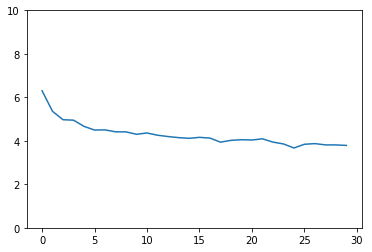

In [40]:
learner.train(train_iter, valid_iter, epochs, batch_size, plot_every, 
              end_train, end_val, src, trg, n_words_trg, teacher_forcing)

In [41]:
teacher_forcing = 0.6


Train: 4.02636455191244 
Valid: 4.0777368433404675


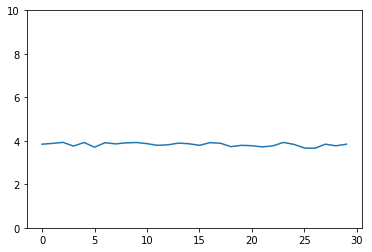

In [42]:
learner.train(train_iter, valid_iter, epochs, batch_size, plot_every, 
              end_train, end_val, src, trg, n_words_trg, teacher_forcing)

In [43]:
teacher_forcing = 0.4


Train: 4.109714927059589 
Valid: 3.847453050094076


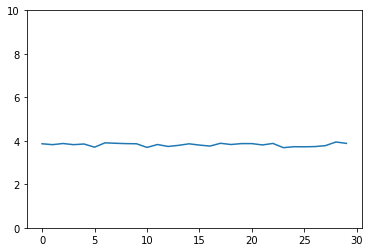

In [44]:
learner.train(train_iter, valid_iter, epochs, batch_size, plot_every, 
              end_train, end_val, src, trg, n_words_trg, teacher_forcing)

In [45]:
teacher_forcing = 0.2


Train: 3.8310373047790907 
Valid: 3.997946250556719


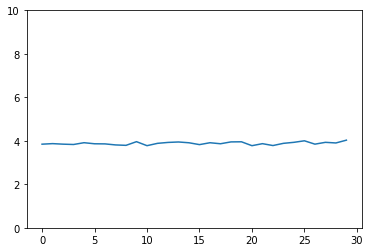

In [46]:
learner.train(train_iter, valid_iter, epochs, batch_size, plot_every, 
              end_train, end_val, src, trg, n_words_trg, teacher_forcing)

In [47]:
teacher_forcing = 0


Train: 3.9827526902208232 
Valid: 3.9728590775244306


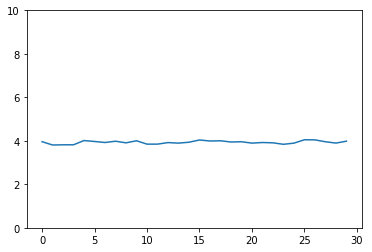

In [48]:
learner.train(train_iter, valid_iter, epochs, batch_size, plot_every, 
              end_train, end_val, src, trg, n_words_trg, teacher_forcing)

In [49]:
t1 = time.time()
t1-t0

17338.646909952164

Loading / saving Multi30k models

(currently there is incompatible version of model in models folder, so this won't work)

In [16]:
enc.load_state_dict(torch.load(f'{model_path_Multi30k}enc.pt'))
dec.load_state_dict(torch.load(f'{model_path_Multi30k}dec.pt'))

In [51]:
torch.save(enc.state_dict(), f'{model_path_Multi30k}enc.pt')
torch.save(dec.state_dict(), f'{model_path_Multi30k}dec.pt')

Example of loading 3rd iteration of Multi30k model.

In [15]:
enc.load_state_dict(torch.load(f'{model_path_Multi30k}module_1_3.pt'))
dec.load_state_dict(torch.load(f'{model_path_Multi30k}module_2_3.pt'))

### Analysis

We won't dig deep into the model's workings / performance. For now, we will only look at examples of the model's translations. This will give us some insight into it's capabilities and we will also be able to better interpret the results given by applying custom metric.

##### LSTM RNN

To get new example, simply reload the line below. 

In [86]:
rand_ex = next(iter(valid_iter))
ex_src,ex_trg = getattr(rand_ex,src),getattr(rand_ex,trg)

These two cells show what we are going to translate and it's human translation.

In [87]:
[SRC.vocab.itos[x] for x in ex_src[:,0]]

['zwei',
 'menschen',
 'unterhalten',
 'sich',
 'bei',
 'einer',
 'roten',
 'telefonzelle',
 'während',
 'in',
 'der',
 'nähe',
 'bauarbeiter',
 'eine',
 'pause',
 'machen',
 '<EOS>']

In [88]:
[TRG.vocab.itos[x] for x in ex_trg[:,0]]

['<SOS>',
 'two',
 'people',
 'are',
 'talking',
 'near',
 'a',
 'red',
 'phone',
 'booth',
 'while',
 'construction',
 'workers',
 'rest',
 'nearby',
 '<EOS>']

Here we use our model to translate the sentence. Choose appropriate translate function.

In [89]:
sent_ids = translate.lstm_rnn(enc,dec,trg_sos_id,trg_eos_id,ex_src)

In [ ]:
sent_ids = translate.lstm_rnn_vls(enc,dec,trg_sos_id,trg_eos_id,pad_src_id,ex_src[:,0][:,None])

Now we can take a look at the sentence our model created.

In [90]:
[TRG.vocab.itos[x] for x in sent_ids]

['two', 'people', 'are', 'a', 'a', 'a', 'a', 'a', 'and', '<EOS>']

Definitely not perfect, but some pattern can be seen. Here I provide some translations without source / target sentences.

In [116]:
for _ in range(10):
    rand_ex = next(iter(valid_iter))
    ex_src,ex_trg = getattr(rand_ex,src),getattr(rand_ex,trg)
    sent_ids = translate.Multi30k(enc, dec, trg_sos_id, trg_eos_id, ex_src)
    print([TRG.vocab.itos[x] for x in sent_ids])

['two', 'dogs', 'dogs', 'are', 'the', 'the', '<EOS>']
['a', 'man', 'and', 'woman', 'woman', 'a', 'a', 'a', 'a', 'a', '<EOS>']
['several', 'men', 'men', 'sitting', 'sitting', 'the', 'in', 'a', 'with', 'with', 'with', 'in', 'a', '<EOS>']
['three', 'girls', 'are', 'on', 'the', 'the', 'in', 'the', 'in', 'the', '<EOS>']
['the', 'people', 'are', 'the', 'in', 'the', 'in', '<EOS>']
['three', 'dogs', 'are', 'in', 'the', 'in', 'the', '<EOS>']
['a', 'woman', 'is', 'standing', 'standing', 'a', 'a', 'a', 'a', 'a', '<EOS>']
['a', 'man', 'in', 'a', 'red', 'shirt', 'is', 'in', 'in', 'in', 'in', 'in', 'in', '<EOS>']
['a', 'man', 'in', 'a', 'standing', 'stands', 'a', 'on', 'a', 'a', 'a', 'a', '<EOS>']
['a', 'dog', 'is', 'a', 'a', 'dog', 'in', '<EOS>']


##### RNNsearch

To get new example, simply reload the line below. 

In [17]:
rand_ex = next(iter(valid_iter))
ex_src,ex_trg = getattr(rand_ex,src),getattr(rand_ex,trg)

These two cells show what we are going to translate and it's human translation.

In [18]:
src_sent = [SRC.vocab.itos[x] for x in ex_src[:,0]]; src_sent

['ein', 'mann', 'sitzt', 'in', 'einem', 'parkenden', '<unk>', '<EOS>']

In [19]:
trg_sent = [TRG.vocab.itos[x] for x in ex_trg[:,0]]; trg_sent

['<SOS>',
 'a',
 'man',
 'is',
 'parked',
 'while',
 'inside',
 'of',
 'a',
 'sanitation',
 'truck',
 '<EOS>']

Translating the sequence.

In [20]:
sent_ids, att = translate.rnnsearch(enc, dec, trg_sos_id, trg_eos_id, 
                                    ex_src)

Here is the resulting sequence.

In [22]:
trans_sent = [TRG.vocab.itos[x] for x in sent_ids]; trans_sent

['a', 'man', 'sitting', 'sitting', 'in', 'a', 'in', 'a', '<EOS>']

And here we can see what words from source sentence contribute the most to the resulting sequence - the attention.

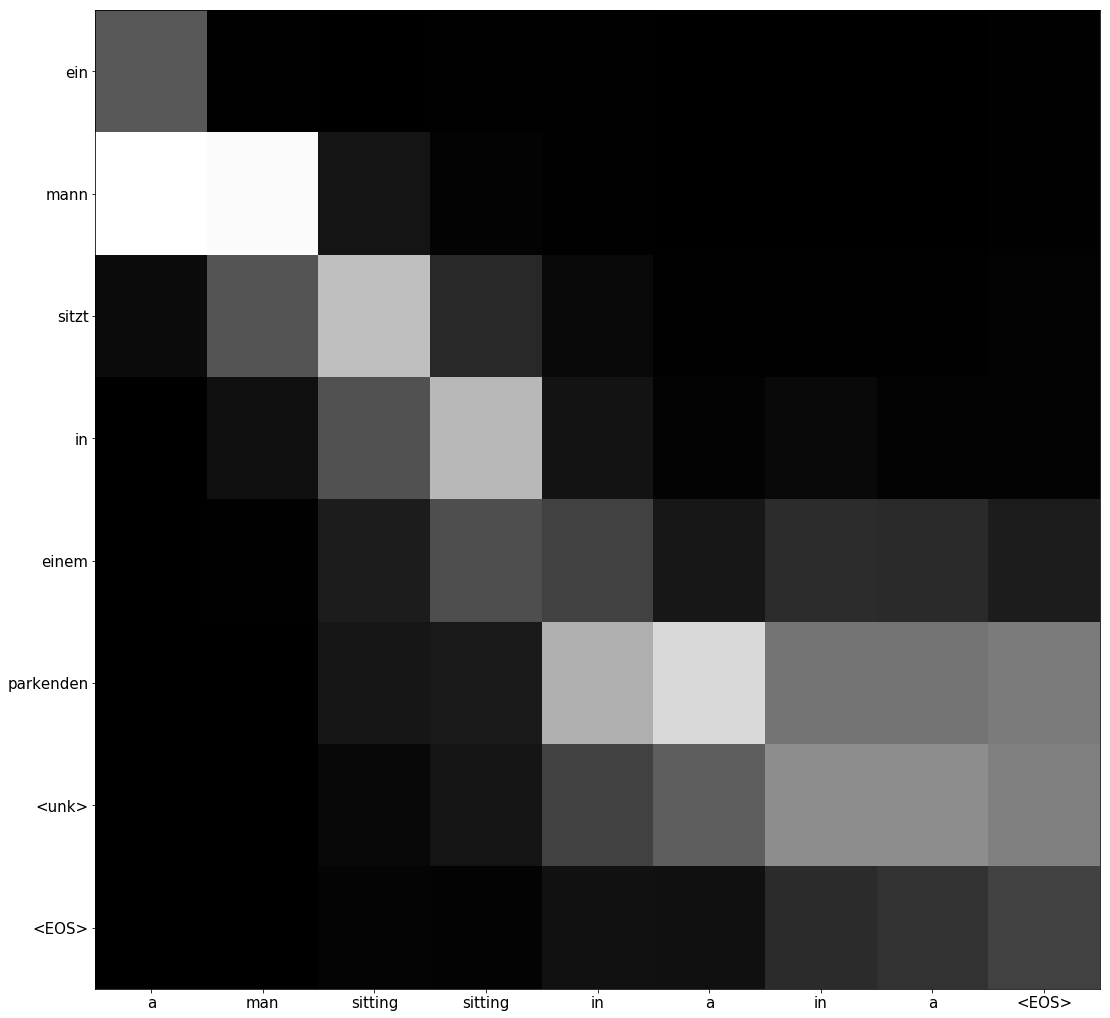

In [23]:
plotAttention(att, src_sent, trans_sent)

Doesn't look bad at all! Here I provide some translations without source / target sentences.

In [58]:
for _ in range(10):
    rand_ex = next(iter(valid_iter))
    ex_src,ex_trg = getattr(rand_ex,src),getattr(rand_ex,trg)
    sent_ids = translate.rnnsearch(enc, dec, trg_sos_id, trg_eos_id, ex_src)
    print([TRG.vocab.itos[x] for x in sent_ids])

['two', 'are', 'stand', 'on', 'a', 'a', 'a', '<EOS>']
['a', 'man', 'in', 'a', 'black', 'tshirt', 'shirt', 'into', 'into', '<EOS>']
['a', 'men', 'on', 'a', 'a', 'boat', 'a', 'a', 'a', 'something', 'something', '<EOS>']
['a', 'group', 'of', 'children', 'children', 'and', 'and', 'and', 'and', 'a', 'on', '<EOS>']
['two', 'kids', 'are', 'in', 'in', 'a', 'a', 'a', 'a', '<EOS>']
['a', 'woman', 'and', 'a', 'child', 'are', 'sitting', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', '<EOS>']
['a', 'baby', 'sitting', 'on', 'a', 'blue', 'blue', '<EOS>']
['a', 'woman', 'working', 'on', 'the', 'at', 'at', 'at', 'a', '<EOS>']
['a', 'boy', 'dressed', 'in', 'a', 'on', 'on', 'a', 'a', 'a', '<EOS>']
['a', 'little', 'girl', 'plays', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'and', 'a', 'and', 'a', '<EOS>']


##### Comparison

In [104]:
num = 0
for par in enc.parameters():
    num += len(par)
for par in dec.parameters():
    num += len(par)

In [105]:
num

52405

*LSTM RNN* 
- ~150 000 examples * ~15 words = ~2 250 000 words
- validation loss = 4.8
- train time ~120 minutes (GeForce GTX 1050 (2GB))
- parameters - 55 203

*RNNsearch* 
- ~60 000 examples * ~15 words = ~900 000 words
- validation loss = 3.97
- train time ~300 minutes (GeForce GTX 1050 (2GB))
- parameters - 52 405

The RNNsearch looks better, but both models could still be improved.

### Summary

In this notebook, I introduced two models for neural machine translation, LSTM RNN and RNNsearch. To train them, we used a small dataset focused on narrow field of language (image captions).

Actual translations and loss comparison can be seen in the analysis part. Both models perform rather poorly. I will continue working on this to achieve some better results.